In [1]:
##############################################################################
# blosc2_grok: Grok (JPEG2000 codec) plugin for Blosc2
#
# Copyright (c) 2023  The Blosc Development Team <blosc@blosc.org>
# https://blosc.org
# License: GNU Affero General Public License v3.0 (see LICENSE.txt)
##############################################################################

"""
Benchmark for compressing blocked images with grok codec.

Data can be downloaded from: http://www.silx.org/pub/nabu/data/compression/lung_raw_2000-2100.h5
"""

'\nBenchmark for compressing blocked images with grok codec.\n\nData can be downloaded from: http://www.silx.org/pub/nabu/data/compression/lung_raw_2000-2100.h5\n'

In [2]:
import h5py
import blosc2
import blosc2_grok
import numpy as np
import hdf5plugin
from skimage.metrics import structural_similarity as ssim
from tqdm import tqdm
import matplotlib.pyplot as plt
from time import time
import itertools
from PIL import Image
import io

In [3]:
# Params for the frame iterator
verbose = False
all_frames = False
meas = {}  # dictionary for storing the measurements

In [4]:
# Register grok codec locally
blosc2.register_codec('grok', 160)

In [5]:
# Open the dataset
data_dir = '/home/faltet/Downloads/'
f = h5py.File(f'{data_dir}/lung_raw_2000-2100.h5', 'r')
dset = f['/data']
if all_frames:
    nframes = dset.shape[0]
else:
    nframes = 1
images_per_chunk = 16
blocks = (1, dset.shape[1], dset.shape[2])
print(f"Compressing dataset of {dset.shape} images ...")

Compressing dataset of (100, 1024, 2048) images ...


In [6]:
# Define the compression and decompression parameters for Blosc2.
# Disable the filters and the splitmode, because these don't work with grok.
cparams = {
    'codec': 160,
    #'nthreads': 16,  # when commented out, this is automatically set to the number of cores
    'filters': [],
    'splitmode': blosc2.SplitMode.NEVER_SPLIT,
}
dparams = {
    #'nthreads': 4,  # when commented out, this is automatically set to the number of cores
}

# Set the default parameters that will be used by grok
grok_params = {
    'cod_format': blosc2_grok.GrkFileFmt.GRK_FMT_JP2,
    'num_threads': 0,
}

In [7]:
def iter_images(verbose=False):
    ret = itertools.chain([1], range(4, images_per_chunk + 1, 4))
    if verbose:
        ret = tqdm(iter_images)
    return ret

In [8]:
for nimages in iter_images(verbose):
    # Compress the dataset with different compression ratios
    quality_mode = f"rates-{nimages}"
    print(f"Quality mode: {quality_mode}")
    ssims = []
    cratios = []
    times = []
    dtimes = []
    range_vals = list(range(1, 11))
    range_vals_str = "range(1, 11)"
    for cratio in range_vals:
        if verbose:
            print(f"Compressing with cratio={cratio}x ...")
        blosc2_grok.set_params_defaults(
            quality_mode=quality_mode.split("-")[0],
            quality_layers=np.array([cratio], dtype=np.float64),
            **grok_params)
    
        # Iterate over the frames
        iter_frames = tqdm(range(0, nframes, nimages)) if verbose else range(0, nframes, nimages)
        for i in iter_frames:
            im = dset[i:i+nimages, ...]
            # Transform the numpy array into a blosc2 array. This is where compression happens.
            t0 = time()
            chunks = (nimages, dset.shape[1], dset.shape[2])
            b2im = blosc2.asarray(im, chunks=chunks, blocks=blocks, cparams=cparams)
            if i == 0:
                times.append(time() - t0)
                cratios.append(b2im.schunk.cratio)
                # Compare with the original image
                t0 = time()
                im2 = b2im[:]
                dtimes.append(time() - t0)
                ssim_ = ssim(im[0], im2[0], data_range=im[0].max() - im[0].min())
                ssims.append(ssim_)
        if verbose:
            print(f"SSIM: {ssim_}")
    meas[quality_mode] = {'ssims': ssims, 'cratios': cratios, 'times': times, 'dtimes': dtimes}

Quality mode: rates-1
Quality mode: rates-4
Quality mode: rates-8
Quality mode: rates-12
Quality mode: rates-16


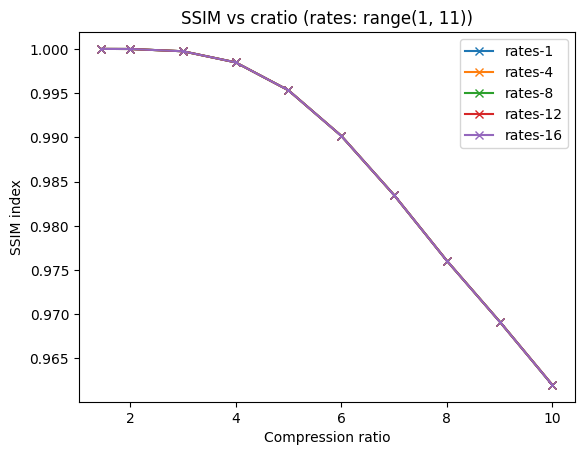

In [9]:
for nimages in iter_images():
    quality_mode = f"rates-{nimages}"
    marker = 'x-'
    label = quality_mode
    plt.plot(meas[quality_mode]['cratios'], meas[quality_mode]['ssims'], marker, label=label)
plt.title(f'SSIM vs cratio ({quality_mode.split("-")[0]}: {range_vals_str})')
plt.xlabel('Compression ratio')
plt.ylabel('SSIM index')
plt.legend()

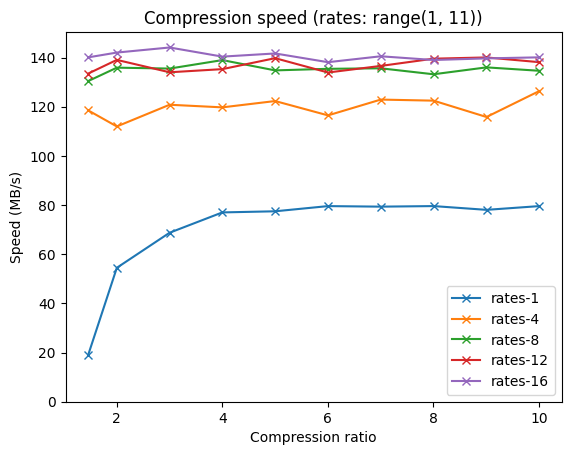

In [10]:
for nimages in iter_images():
    chunks = (nimages, dset.shape[1], dset.shape[2])
    sizeMB = np.prod(chunks) / 2**20
    quality_mode = f"rates-{nimages}"
    marker = 'x-'
    label = quality_mode
    plt.plot(meas[quality_mode]['cratios'], sizeMB / meas[quality_mode]['times'], marker, label=label)
plt.title(f'Compression speed ({quality_mode.split("-")[0]}: {range_vals_str})')
plt.xlabel('Compression ratio')
plt.ylabel('Speed (MB/s)')
plt.ylim(0)
plt.legend()

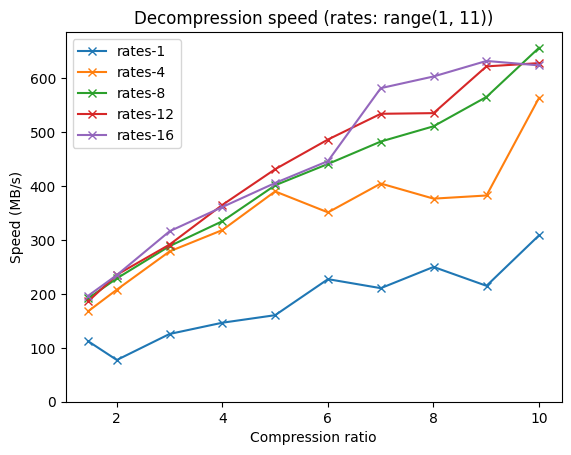

In [11]:
for nimages in iter_images():
    chunks = (nimages, dset.shape[1], dset.shape[2])
    sizeMB = np.prod(chunks) / 2**20
    quality_mode = f"rates-{nimages}"
    marker = 'x-'
    label = quality_mode
    plt.plot(meas[quality_mode]['cratios'], sizeMB / meas[quality_mode]['dtimes'], marker, label=label)
plt.title(f'Decompression speed ({quality_mode.split("-")[0]}: {range_vals_str})')
plt.xlabel('Compression ratio')
plt.ylabel('Speed (MB/s)')
plt.ylim(0)
plt.legend()

In [12]:
for nimages in iter_images(verbose):
    # Compress the dataset with different compression ratios
    quality_mode = f"dB-{nimages}"
    print(f"Quality mode: {quality_mode}")
    ssims = []
    cratios = []
    times = []
    dtimes = []
    range_vals = list(range(90, 45, -5))
    range_vals_str = "range(90, 45, -5)"
    for quality in range_vals:
        if verbose:
            print(f"Compressing with quality={quality}dB ...")
        blosc2_grok.set_params_defaults(
            quality_mode=quality_mode.split("-")[0],
            quality_layers=np.array([quality], dtype=np.float64),
            **grok_params)
    
        # Iterate over the frames
        iter_frames = tqdm(range(0, nframes, nimages)) if verbose else range(0, nframes, nimages)
        for i in iter_frames:
            im = dset[i:i+nimages, ...]
            # Transform the numpy array into a blosc2 array. This is where compression happens.
            t0 = time()
            chunks = (nimages, dset.shape[1], dset.shape[2])
            b2im = blosc2.asarray(im, chunks=chunks, blocks=blocks, cparams=cparams)
            if i == 0:
                times.append(time() - t0)
                cratios.append(b2im.schunk.cratio)
                # Compare with the original image
                t0 = time()
                im2 = b2im[:]
                dtimes.append(time() - t0)
                ssim_ = ssim(im[0], im2[0], data_range=im[0].max() - im[0].min())
                ssims.append(ssim_)
        if verbose:
            print(f"SSIM: {ssim_}")
    meas[quality_mode] = {'ssims': ssims, 'cratios': cratios, 'times': times, 'dtimes': dtimes}

Quality mode: dB-1
Quality mode: dB-4
Quality mode: dB-8
Quality mode: dB-12
Quality mode: dB-16


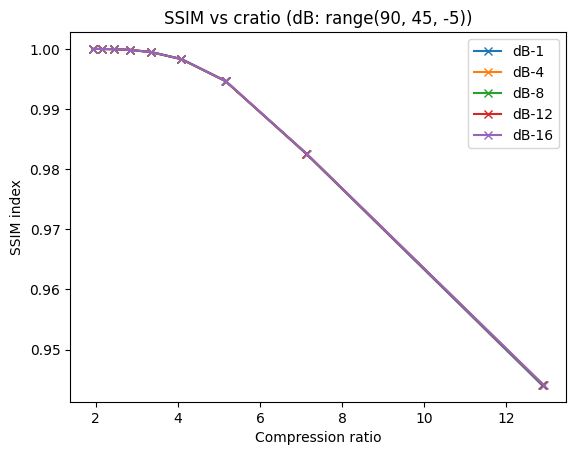

In [13]:
for nimages in iter_images():
    quality_mode = f"dB-{nimages}"
    marker = 'x-'
    label = quality_mode
    plt.plot(meas[quality_mode]['cratios'], meas[quality_mode]['ssims'], marker, label=label)
plt.title(f'SSIM vs cratio ({quality_mode.split("-")[0]}: {range_vals_str})')
plt.xlabel('Compression ratio')
plt.ylabel('SSIM index')
plt.legend()

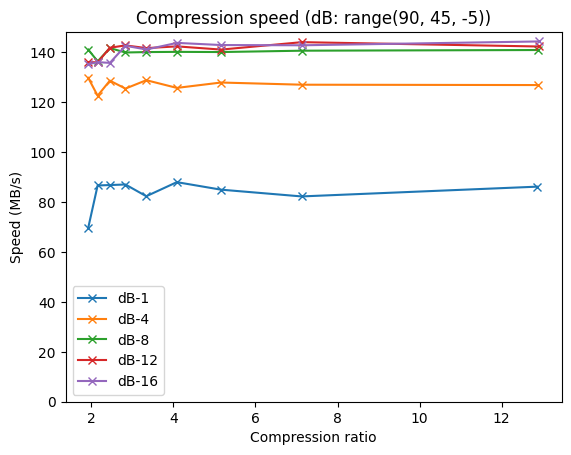

In [14]:
for nimages in iter_images():
    chunks = (nimages, dset.shape[1], dset.shape[2])
    sizeMB = np.prod(chunks) / 2**20
    quality_mode = f"dB-{nimages}"
    marker = 'x-'
    label = quality_mode
    plt.plot(meas[quality_mode]['cratios'], sizeMB / meas[quality_mode]['times'], marker, label=label)
plt.title(f'Compression speed ({quality_mode.split("-")[0]}: {range_vals_str})')
plt.xlabel('Compression ratio')
plt.ylabel('Speed (MB/s)')
plt.ylim(0)
plt.legend()

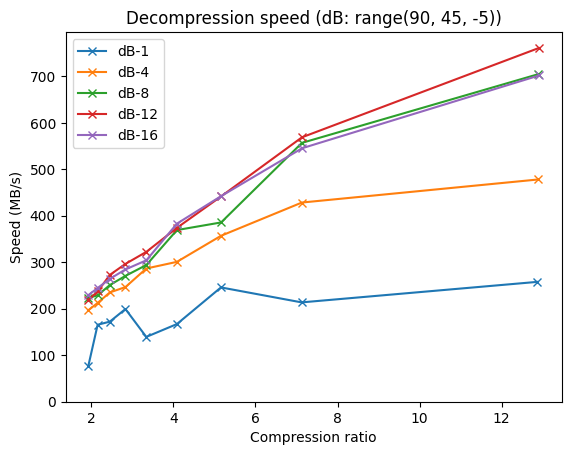

In [15]:
for nimages in iter_images():
    chunks = (nimages, dset.shape[1], dset.shape[2])
    sizeMB = np.prod(chunks) / 2**20
    quality_mode = f"dB-{nimages}"
    marker = 'x-'
    label = quality_mode
    plt.plot(meas[quality_mode]['cratios'], sizeMB / meas[quality_mode]['dtimes'], marker, label=label)
plt.title(f'Decompression speed ({quality_mode.split("-")[0]}: {range_vals_str})')
plt.xlabel('Compression ratio')
plt.ylabel('Speed (MB/s)')
plt.ylim(0)
plt.legend()

In [16]:
for nimages in range(1, 2):
    # Compress the dataset with different compression ratios
    quality_mode = "dB-OpenJPEG"
    print(f"Quality mode: {quality_mode}")
    ssims = []
    cratios = []
    times = []
    dtimes = []
    range_vals = list(range(90, 45, -5))
    range_vals_str = "range(90, 45, -5)"
    for quality in range_vals:
        if verbose:
            print(f"Compressing with OpenJPEG and quality={quality}dB ...")
        blosc2_grok.set_params_defaults(
            quality_mode=quality_mode.split("-")[0],
            quality_layers=np.array([quality], dtype=np.float64),
            **grok_params)
    
        # Iterate over the frames
        iter_frames = tqdm(range(0, nframes, nimages)) if verbose else range(0, nframes, nimages)
        for i in iter_frames:
            im = dset[i, ...]
            # Use pillow for compressing
            j2kim = Image.fromarray(im)
            t0 = time()
            j2kbio = io.BytesIO()
            j2kim.save(j2kbio, format='JPEG2000', quality_mode="dB", quality_layers=[quality])
            if i == 0:
                times.append(time() - t0)
                im_bytes = j2kbio.getvalue()
                cratio = im.nbytes / len(im_bytes)
                cratios.append(cratio)
                t0 = time()
                im2 = Image.open(io.BytesIO(im_bytes))
                im2 = np.array(im2)
                dtimes.append(time() - t0)
                #ssim_ = ssim(im[0], im2[0], data_range=im[0].max() - im[0].min())
                ssim_ = ssim(im, im2, data_range=im.max() - im.min())
                ssims.append(ssim_)
        if verbose:
            print(f"SSIM: {ssim_}")
    meas[quality_mode] = {'ssims': ssims, 'cratios': cratios, 'times': times, 'dtimes': dtimes}

Quality mode: dB-OpenJPEG


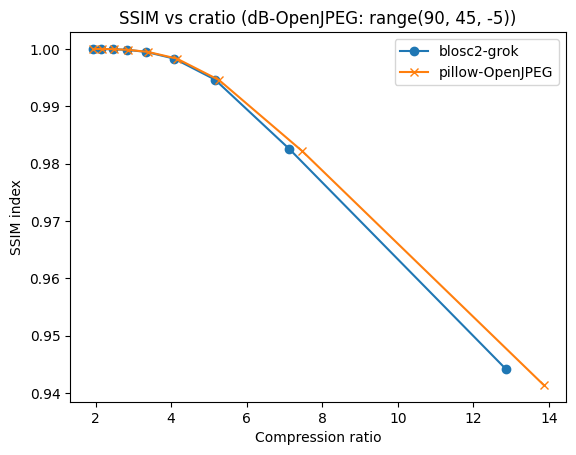

In [17]:
plt.plot(meas["dB-1"]['cratios'], meas["dB-1"]['ssims'], 'o-', label="blosc2-grok")
plt.plot(meas[quality_mode]['cratios'], meas[quality_mode]['ssims'], 'x-', label="pillow-OpenJPEG")
plt.title(f'SSIM vs cratio ({quality_mode}: {range_vals_str})')
plt.xlabel('Compression ratio')
plt.ylabel('SSIM index')
plt.legend()

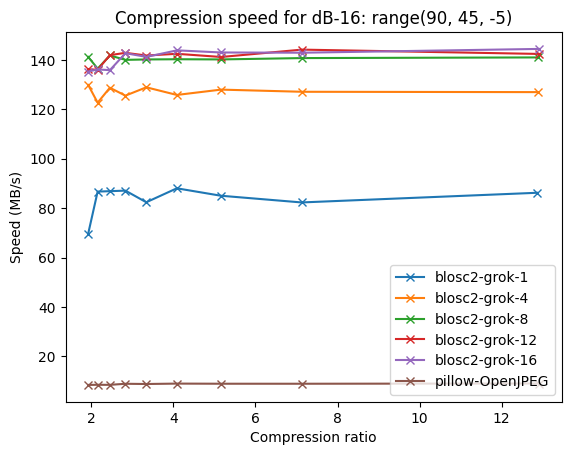

In [18]:
for nimages in iter_images():
    chunks = (nimages, dset.shape[1], dset.shape[2])
    sizeMB = np.prod(chunks) / 2**20
    quality_mode = f"dB-{nimages}"
    marker = 'x-'
    label = f"blosc2-grok-{nimages}"
    plt.plot(meas[quality_mode]['cratios'], sizeMB / meas[quality_mode]['times'], marker, label=label)
sizeMB = np.prod(dset.shape[1:]) / 2**20
plt.plot(meas[quality_mode]['cratios'], sizeMB / meas[quality_mode]['times'], 'x-', label="pillow-OpenJPEG")
plt.title(f'Compression speed for {quality_mode}: {range_vals_str}')
plt.xlabel('Compression ratio')
plt.ylabel('Speed (MB/s)')
plt.legend()

In [19]:
sizeMB / meas[quality_mode]['times']

array([8.45348001, 8.50681013, 8.48884427, 8.91744836, 8.82417826,
       8.98949266, 8.93564839, 8.92969387, 9.02570547])

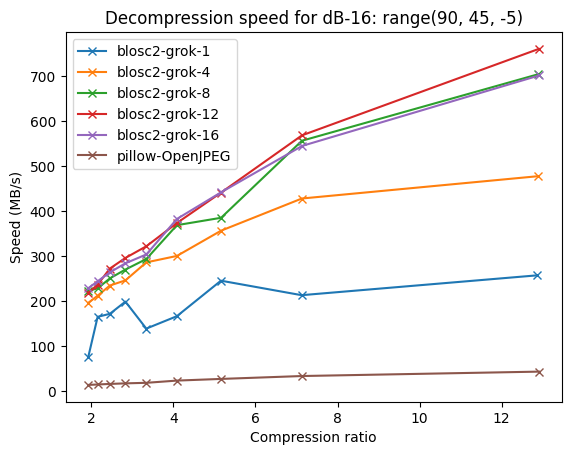

In [20]:
for nimages in iter_images():
    chunks = (nimages, dset.shape[1], dset.shape[2])
    sizeMB = np.prod(chunks) / 2**20
    quality_mode = f"dB-{nimages}"
    marker = 'x-'
    label = f"blosc2-grok-{nimages}"
    plt.plot(meas[quality_mode]['cratios'], sizeMB / meas[quality_mode]['dtimes'], marker, label=label)
sizeMB = np.prod(dset.shape[1:]) / 2**20
plt.plot(meas[quality_mode]['cratios'], sizeMB / meas[quality_mode]['dtimes'], 'x-', label="pillow-OpenJPEG")
plt.title(f'Decompression speed for {quality_mode}: {range_vals_str}')
plt.xlabel('Compression ratio')
plt.ylabel('Speed (MB/s)')
plt.legend()

In [21]:
sizeMB / meas[quality_mode]['dtimes']

array([14.31705856, 15.2929719 , 16.52725775, 17.78686988, 19.01829369,
       23.94767749, 27.64940407, 34.08382192, 43.86888401])